In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 10
NUM_EPOCHS = 500
NUM_ROUTING_ITERATIONS = 3

In [3]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [4]:
def augmentation(x, max_shift=2):
    _, _, height, width = x.size()

    h_shift, w_shift = np.random.randint(-max_shift, max_shift + 1, size=2)
    source_height_slice = slice(max(0, h_shift), h_shift + height)
    source_width_slice = slice(max(0, w_shift), w_shift + width)
    target_height_slice = slice(max(0, -h_shift), -h_shift + height)
    target_width_slice = slice(max(0, -w_shift), -w_shift + width)

    shifted_image = torch.zeros(*x.size())
    shifted_image[ :, :, source_height_slice, source_width_slice] = x[:, :, target_height_slice, target_width_slice]
    return shifted_image.float()

In [5]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None,
                 num_iterations=NUM_ROUTING_ITERATIONS):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        self.num_capsules = num_capsules

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in
                 range(num_capsules)])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]

            logits = Variable(torch.zeros(*priors.size())).cuda()
            for i in range(self.num_iterations):
                probs = softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
        else:
            outputs = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            outputs = self.squash(outputs)

        return outputs

In [6]:
class CapsuleNet(nn.Module):
    def __init__(self):
        super(CapsuleNet, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=20, out_channels=256, kernel_size=9, stride=1)
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32,
                                             kernel_size=9, stride=2)
        self.digit_capsules = CapsuleLayer(num_capsules=NUM_CLASSES, num_route_nodes=96, in_channels=8,
                                           out_channels=16)

        self.final_layer = nn.Linear(NUM_CLASSES, 1)
        
        self.decoder = nn.Sequential(
            nn.Linear(16 * NUM_CLASSES, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3072),
            nn.Sigmoid()
        )

    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)

        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes1 = 100*classes
        classes = self.final_layer(classes1)
        classes1 = F.softmax(classes1, dim=-1)

        if y is None:
            # In all batches, get the most active capsule.
            _, max_length_indices = classes1.max(dim=1)
            y = Variable(torch.eye(NUM_CLASSES)).cuda().index_select(dim=0, index=max_length_indices.data)

        reconstructions = self.decoder((x * y[:, :, None]).reshape(x.size(0), -1))

        return classes, reconstructions

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CapsuleNet().to(device=device)

In [8]:
x = torch.randn(5, 20, 22)
x = x.to(device=device)
y = model(x)
print(y[0].shape)
print(y[0])

torch.Size([5, 1])
tensor([[0.0213],
        [1.1681],
        [0.3362],
        [1.3374],
        [0.6015]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [14]:
trainX=[]
trainY=[]

In [15]:
n_future=1
n_past=20

In [16]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [17]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [18]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [19]:
data,label=trainX,trainY

In [20]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [21]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [22]:
label=standardization(label)

In [23]:
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data,  label)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [25]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        output = model(data)
        loss = 10*criterion(output[0], targets)
        losses.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.8297281861305237
Epoch: 1 Loss: 1.062882661819458
Epoch: 2 Loss: 0.8907609581947327
Epoch: 3 Loss: 0.9097558856010437
Epoch: 4 Loss: 0.707528829574585
Epoch: 5 Loss: 1.0530325174331665
Epoch: 6 Loss: 0.737834632396698
Epoch: 7 Loss: 0.716423749923706
Epoch: 8 Loss: 0.6621801257133484
Epoch: 9 Loss: 0.6716965436935425
Epoch: 10 Loss: 0.6771284341812134
Epoch: 11 Loss: 0.6691393256187439
Epoch: 12 Loss: 0.6482076644897461
Epoch: 13 Loss: 0.6286680102348328
Epoch: 14 Loss: 0.6327351331710815
Epoch: 15 Loss: 0.5926945209503174
Epoch: 16 Loss: 0.542048454284668
Epoch: 17 Loss: 0.7228023409843445
Epoch: 18 Loss: 0.6562706828117371
Epoch: 19 Loss: 0.6464327573776245
Epoch: 20 Loss: 0.6482937932014465
Epoch: 21 Loss: 0.6797366738319397
Epoch: 22 Loss: 0.655854344367981
Epoch: 23 Loss: 0.55862957239151
Epoch: 24 Loss: 0.5417083501815796
Epoch: 25 Loss: 0.7960097789764404
Epoch: 26 Loss: 0.5802671909332275
Epoch: 27 Loss: 0.568301796913147
Epoch: 28 Loss: 1.0714324712753296
Epoc

Epoch: 230 Loss: 0.2920377850532532
Epoch: 231 Loss: 0.2481759786605835
Epoch: 232 Loss: 0.38137882947921753
Epoch: 233 Loss: 0.32281693816185
Epoch: 234 Loss: 0.2734311521053314
Epoch: 235 Loss: 0.36220890283584595
Epoch: 236 Loss: 0.237264484167099
Epoch: 237 Loss: 0.42839038372039795
Epoch: 238 Loss: 0.322841078042984
Epoch: 239 Loss: 0.30045780539512634
Epoch: 240 Loss: 0.3071210980415344
Epoch: 241 Loss: 0.2763582468032837
Epoch: 242 Loss: 0.3395373821258545
Epoch: 243 Loss: 0.24988055229187012
Epoch: 244 Loss: 0.3922443091869354
Epoch: 245 Loss: 0.2857511639595032
Epoch: 246 Loss: 0.4077506363391876
Epoch: 247 Loss: 0.3608800172805786
Epoch: 248 Loss: 0.25875014066696167
Epoch: 249 Loss: 0.33562853932380676
Epoch: 250 Loss: 0.27357468008995056
Epoch: 251 Loss: 0.3570716381072998
Epoch: 252 Loss: 0.23699265718460083
Epoch: 253 Loss: 0.313806414604187
Epoch: 254 Loss: 0.3129422068595886
Epoch: 255 Loss: 0.3403059244155884
Epoch: 256 Loss: 0.2314559370279312
Epoch: 257 Loss: 0.39689

Epoch: 455 Loss: 0.2772882282733917
Epoch: 456 Loss: 0.20353758335113525
Epoch: 457 Loss: 0.23386737704277039
Epoch: 458 Loss: 0.2578703761100769
Epoch: 459 Loss: 0.21702183783054352
Epoch: 460 Loss: 0.25008803606033325
Epoch: 461 Loss: 0.23974591493606567
Epoch: 462 Loss: 0.2409195750951767
Epoch: 463 Loss: 0.20700789988040924
Epoch: 464 Loss: 0.2616673409938812
Epoch: 465 Loss: 0.25462570786476135
Epoch: 466 Loss: 0.20772585272789001
Epoch: 467 Loss: 0.2606394290924072
Epoch: 468 Loss: 0.1996052861213684
Epoch: 469 Loss: 0.2600192725658417
Epoch: 470 Loss: 0.18911752104759216
Epoch: 471 Loss: 0.27665507793426514
Epoch: 472 Loss: 0.23393622040748596
Epoch: 473 Loss: 0.37992623448371887
Epoch: 474 Loss: 0.25820839405059814
Epoch: 475 Loss: 0.23774681985378265
Epoch: 476 Loss: 0.22072359919548035
Epoch: 477 Loss: 0.25258129835128784
Epoch: 478 Loss: 0.23981742560863495
Epoch: 479 Loss: 0.31785157322883606
Epoch: 480 Loss: 0.19096137583255768
Epoch: 481 Loss: 0.2750677764415741
Epoch: 48

Epoch: 679 Loss: 0.24544161558151245
Epoch: 680 Loss: 0.2413172423839569
Epoch: 681 Loss: 0.20807930827140808
Epoch: 682 Loss: 0.2457745522260666
Epoch: 683 Loss: 0.1957145482301712
Epoch: 684 Loss: 0.2704276740550995
Epoch: 685 Loss: 0.1968184858560562
Epoch: 686 Loss: 0.21022507548332214
Epoch: 687 Loss: 0.22794348001480103
Epoch: 688 Loss: 0.17318207025527954
Epoch: 689 Loss: 0.23762105405330658
Epoch: 690 Loss: 0.1886078417301178
Epoch: 691 Loss: 0.2157772183418274
Epoch: 692 Loss: 0.1814197152853012
Epoch: 693 Loss: 0.26967760920524597
Epoch: 694 Loss: 0.2171386182308197
Epoch: 695 Loss: 0.20034344494342804
Epoch: 696 Loss: 0.22574178874492645
Epoch: 697 Loss: 0.251762330532074
Epoch: 698 Loss: 0.2469143271446228
Epoch: 699 Loss: 0.2110641449689865
Epoch: 700 Loss: 0.20441991090774536
Epoch: 701 Loss: 0.2078329622745514
Epoch: 702 Loss: 0.20896553993225098
Epoch: 703 Loss: 0.2432212084531784
Epoch: 704 Loss: 0.25640225410461426
Epoch: 705 Loss: 0.17894452810287476
Epoch: 706 Loss:

Epoch: 903 Loss: 0.19955553114414215
Epoch: 904 Loss: 0.20853492617607117
Epoch: 905 Loss: 0.20258042216300964
Epoch: 906 Loss: 0.17592066526412964
Epoch: 907 Loss: 0.23000963032245636
Epoch: 908 Loss: 0.19383779168128967
Epoch: 909 Loss: 0.19906191527843475
Epoch: 910 Loss: 0.2658748924732208
Epoch: 911 Loss: 0.1732790172100067
Epoch: 912 Loss: 0.2741839587688446
Epoch: 913 Loss: 0.19647249579429626
Epoch: 914 Loss: 0.2018655240535736
Epoch: 915 Loss: 0.1705819070339203
Epoch: 916 Loss: 0.2284778356552124
Epoch: 917 Loss: 0.17959119379520416
Epoch: 918 Loss: 0.27453896403312683
Epoch: 919 Loss: 0.171176940202713
Epoch: 920 Loss: 0.2515130937099457
Epoch: 921 Loss: 0.17228823900222778
Epoch: 922 Loss: 0.24491900205612183
Epoch: 923 Loss: 0.16548128426074982
Epoch: 924 Loss: 0.2676484286785126
Epoch: 925 Loss: 0.2161511778831482
Epoch: 926 Loss: 0.23038020730018616
Epoch: 927 Loss: 0.18409943580627441
Epoch: 928 Loss: 0.19995176792144775
Epoch: 929 Loss: 0.2099054455757141
Epoch: 930 Lo

In [26]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [27]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [28]:
trainY_copy_=standardization(trainY_copy_)

In [29]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [30]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output=model(data)
    predictions+=output[0].tolist()

In [31]:
predictions = np.array(predictions)

In [32]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

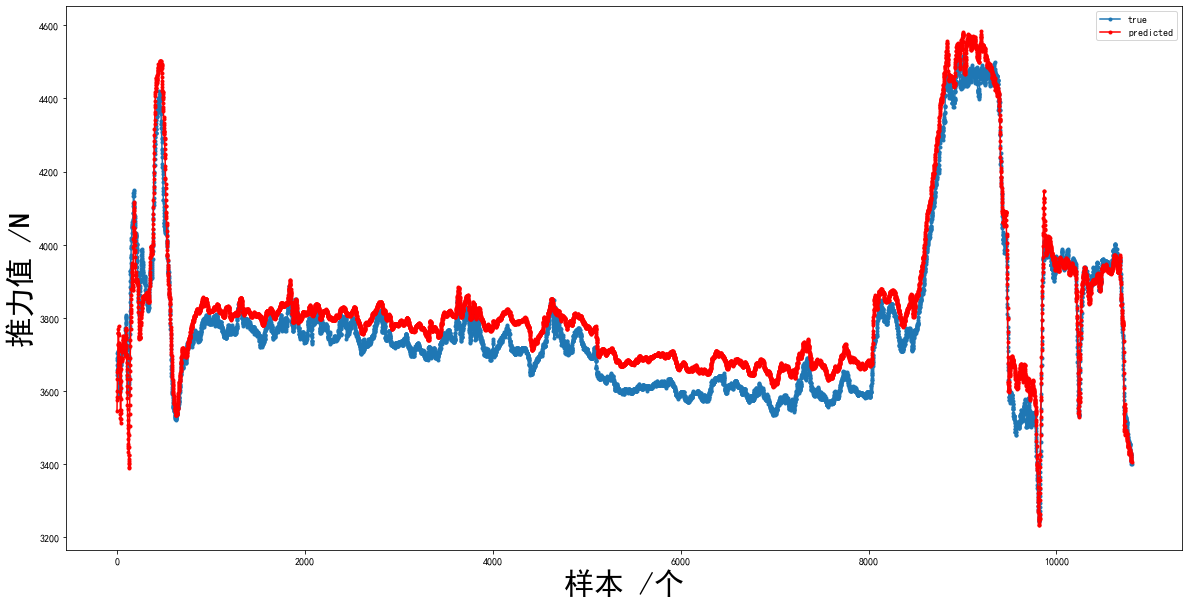

In [33]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 